In [ ]:
# Jovian Commit Essentials
# Please retain and execute this cell without modifying the contents for `jovian.commit` to work
!pip install jovian --upgrade -q
import jovian
jovian.set_project('deep-learning-project')
jovian.set_colab_id('1sc4faqvCIZsdV0hzXu7VE7iefJzmSw-5')

In [ ]:
!pip install jovian --upgrade --quiet

# Flower Classification Using PyTorch & ResNet9

## Identifying Flower Species Using Deep Learning and PyTorch
### TODO - Introduction 
We are going to do it in the following steps:
1. Pick a dataset
2. Download the Dataset
3. Import the dataset using PyTorch
4. Explore the dataset
5. Prepare the dataset for training
6. Move the dataset to the GPU
7. define a neural network
8. Train the model
9. Evaluate on the validation data set
10. Make predictions on sample images
11. Iterate on it with different networks, regularization & hyper parameters
12. Save the model weights
13. Record the metrics
14. Conclusions - summarize your learning & identify opportunities for future work

# Download the dataset
Using **opendatasets** and download the dataset from https://www.kaggle.com/alxmamaev/flowers-recognition/data

This dataset contains 4242 images of flowers.

The pictures are divided into five classes: chamomile, tulip, rose, sunflower, dandelion.
For each class there are about 800 photos. Photos are not high resolution, about 320x240 pixels. Photos are not reduced to a single size, they have different proportions!

In [ ]:
!pip install opendatasets --upgrade --quiet

In [ ]:
import os
import shutil

if os.path.exists('./flowers-recognition'):
  shutil.rmtree('./flowers-recognition')

In [ ]:
import opendatasets as od

dataset_url = 'https://www.kaggle.com/alxmamaev/flowers-recognition/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: venupodugu
Your Kaggle Key: ··········


  5%|▍         | 22.0M/450M [00:00<00:01, 227MB/s]

100%|██████████| 450M/450M [00:02<00:00, 232MB/s]


In [ ]:
data_dir = './flowers-recognition/flowers/'

In [ ]:
os.listdir(data_dir)

['flowers', 'dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

In [ ]:
shutil.rmtree(data_dir +'/flowers')

In [ ]:
os.listdir(data_dir)

['dandelion', 'rose', 'daisy', 'sunflower', 'tulip']

# Import the dataset into PyTorch
Use the **ImageFolder** class from **torchvision**.

In [ ]:
from torchvision.datasets import ImageFolder

dataset = ImageFolder(data_dir)
len(dataset)

4323

In [ ]:
dataset[0]

(<PIL.Image.Image image mode=RGB size=320x263 at 0x7FAA4C2E25F8>, 0)

In [ ]:
dataset.classes

['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

## Sample images from the dataset

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

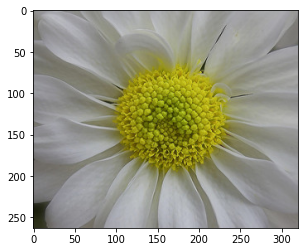

In [ ]:
img, label = dataset[0]
plt.imshow(img)

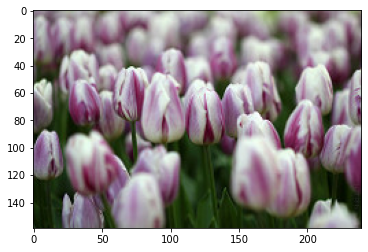

In [ ]:
img, label = dataset[3500]
plt.imshow(img)

When we build the deep learning model we need all the images of same size.
We have images of different sizes in this dataset. We need to crop them

In [ ]:
import torchvision.transforms as tt

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(224),
                                           tt.RandomCrop(224),
                                            tt.ToTensor()]))

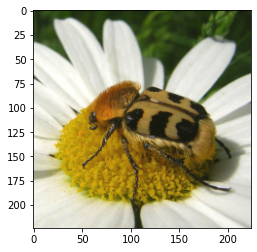

In [ ]:
img, label = dataset[120]
plt.imshow(img.permute((1, 2, 0)))

## Splitting the dataset into Training and Validation datasets.
Use **random_split** class from **torch.utils.data**

In [ ]:
val_pct = 0.1
val_size = int(len(dataset) * val_pct)
train_size = len(dataset) - val_size

train_size, val_size

(3891, 432)

In [ ]:
from torch.utils.data import random_split

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

(3891, 432)

## Creating Dataloaders
Use **DataLoader** class from **torch.utils.data**

In [ ]:
batch_size = 32

In [ ]:
from torch.utils.data import DataLoader

train_dl = DataLoader(train_ds, 
                      batch_size,
                      shuffle = True,
                      num_workers = 4,
                      pin_memory = True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    shuffle = True,
                    num_workers = 4, 
                    pin_memory = True)

let's observe a batch of images from the dataset.

Use **make_grid** from **torchvision.utils**

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12,6))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

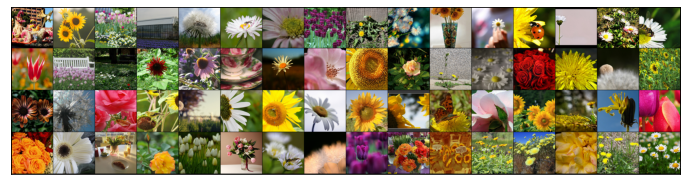

In [ ]:
show_batch(train_dl)

Find the number of images in each class to check whether the dataset is balanced or not.

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':', len(os.listdir(data_dir + '/' + cls)))

dandelion : 1055
rose : 784
daisy : 769
sunflower : 734
tulip : 984


# Utility functions and classes
## GPU Utilities

To seamlessly use a GPU, if one is available, we define a couple of helper functions (get_default_device & to_device) and a helper class DeviceDataLoader to move our model & data to the GPU as required. 

In [ ]:
import torch

def get_default_device():
  """ Pick GPU if available, else CPU """
  if torch.cuda.is_available():
    return torch.device('cuda')
  else:
    return torch.device('cpu')

def to_device(data, device):
  """ Move tensor(s) to chosen device """
  if isinstance(data, (list, tuple)):
     return [to_device(x, device) for x in data]
  return data.to(device, non_blocking=True)

class DeviceDataLoader():
  """ Wrap a dataloader to move data to a device """
  def __init__(self, dl, device):
    self.dl = dl
    self.device = device

  def __iter__(self):
    """ Yield a batch of data after moving it to device """
    for b in self.dl:
      yield to_device(b, self.device)

  def __len__(self):
    """ Number of batches """
    return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

Based on where you're running this notebook, your default device could be a CPU (torch.device('cpu')) or a GPU (torch.device('cuda'))

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img, label = dataset[0]
img.shape

torch.Size([3, 224, 224])

In [ ]:
img.device

device(type='cpu')

In [ ]:
img_gpu = to_device(img, device)
img_gpu.device

device(type='cuda', index=0)

We can now wrap our training and validation data loaders using DeviceDataLoader for automatically transferring batches of data to the GPU (if available), and use to_device to move our model to the GPU (if available).

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

## Model & Training Utilities
Let's define the model by extending an ImageClassificationBase class which contains helper methods for training & validation.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        """ Calculate loss for a batch of training data """
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        """ Calculate loss and accuracy for a batch of validation data """
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


We'll define two functions: **fit** and **evaluate** to train the model using gradient descent and evaluate its performance on the validation set.

In [ ]:
@torch.no_grad()
def evaluate(model, val_loader):
    """ Evaluates the model's performance on the validation set """
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

# Defining the Model
Model with Residual Blocks and Batch Normalization
One of the key changes to our CNN model this time is the addition of the resudial block, which adds the original input back to the output feature map obtained by passing the input through one or more convolutional layers.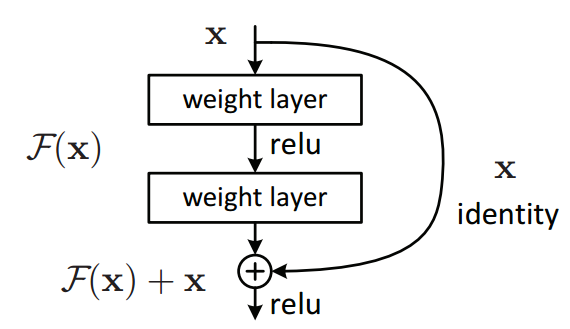

Go through the following blog posts to learn more:

Why and how residual blocks work: https://towardsdatascience.com/residual-blocks-building-blocks-of-resnet-fd90ca15d6ec
Batch normalization and dropout explained: https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd
We will use the ResNet9 architecture, as described in this blog series :

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        
        # Input: 64 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) #  64 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) #  64 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128), #  64 x 128 x 32 x 32
                                  conv_block(128, 128)) #  64 x 128 x 32 x 32
        
        self.conv3 = conv_block(128, 256, pool=True) #  64 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) #  64 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), #  64 x 512 x 8 x 8
                                  conv_block(512, 512))#  64 x 512 x 8 x 8
        
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), #  64 x 512 x 1 x 1
                                        nn.Flatten(), # 64 x 2048
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

Pass one batch of input tensor through the model.

In [ ]:
torch.cuda.empty_cache()

for batch in train_dl:
  images, labels = batch
  print('images.shape', images.shape), 
  print('images.device', images.device)
  preds = model(images)
  print('preds.shape', preds.shape)
  print(preds)
  break

images.shape torch.Size([32, 3, 224, 224])
images.device cuda:0
preds.shape torch.Size([32, 5])
tensor([[ 0.8464,  0.0967,  1.7384,  0.9302,  0.7721],
        [-3.6537,  0.2766,  2.3645, -1.2110,  0.3065],
        [ 0.5399, -2.2698,  5.1589, -1.5508, -1.0008],
        [-1.2414, -0.0482,  3.1394, -4.6613,  2.5036],
        [-1.3897,  1.5180,  0.8893, -1.3622, -2.8082],
        [-3.6628,  0.5383,  2.7520, -0.5348, -0.1573],
        [-0.7130,  0.6788,  4.3820, -1.4262,  2.4117],
        [-0.6603, -0.1210,  3.0108, -3.9907,  2.2651],
        [-1.5941, -2.0655,  4.0877, -2.2414,  1.2572],
        [-0.3478, -0.2074,  0.5725,  0.0562, -0.0303],
        [-1.6548,  0.3793,  0.2457, -2.1557,  0.2900],
        [-3.0889, -2.0747,  1.0150, -0.0799,  0.0785],
        [-1.9540,  1.3866,  3.5968, -0.4610, -1.2575],
        [-0.3178,  1.8943,  1.9525,  0.1584,  2.2704],
        [-1.5908,  1.4702,  1.1706, -2.2399,  2.2781],
        [-0.5763,  1.1746,  0.9360, -0.0285,  0.1219],
        [-3.4438,  0.860

### Saving the notebook to jovian

In [ ]:
!pip install jovian --quiet

In [ ]:
jovian.commit(project = 'deep-learning-project')

[jovian] Detected Colab notebook...
[jovian] Please enter your API key ( from https://jovian.ai/ ):
API KEY: 

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.2209821492433548, 'val_loss': 1.6058745384216309}]

In [ ]:
history += fit(5, 0.001, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 1.3128, val_loss: 0.9920, val_acc: 0.6205
Epoch [1], train_loss: 1.0036, val_loss: 0.9950, val_acc: 0.6496
Epoch [2], train_loss: 0.9191, val_loss: 1.0275, val_acc: 0.5848
Epoch [3], train_loss: 0.7718, val_loss: 0.8593, val_acc: 0.7054
Epoch [4], train_loss: 0.7624, val_loss: 0.7886, val_acc: 0.7232


In [ ]:
history += fit(3, 0.0005, model, train_dl, valid_dl, torch.optim.Adam)

Epoch [0], train_loss: 0.7121, val_loss: 0.6933, val_acc: 0.7299
Epoch [1], train_loss: 0.5966, val_loss: 0.5878, val_acc: 0.7924
Epoch [2], train_loss: 0.5477, val_loss: 0.6560, val_acc: 0.7321


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.4809, val_loss: 0.5927, val_acc: 0.7924
Epoch [1], train_loss: 0.4725, val_loss: 0.5732, val_acc: 0.7991
Epoch [2], train_loss: 0.4448, val_loss: 0.5910, val_acc: 0.7924
Epoch [3], train_loss: 0.4579, val_loss: 0.5607, val_acc: 0.8013
Epoch [4], train_loss: 0.4483, val_loss: 0.5721, val_acc: 0.7969


In [ ]:
history += fit(5, 0.0001, model, train_dl, valid_dl)

Epoch [0], train_loss: 0.4438, val_loss: 0.5713, val_acc: 0.7969
Epoch [1], train_loss: 0.4484, val_loss: 0.5474, val_acc: 0.7946
Epoch [2], train_loss: 0.4442, val_loss: 0.5654, val_acc: 0.8013
Epoch [3], train_loss: 0.4426, val_loss: 0.5696, val_acc: 0.7946
Epoch [4], train_loss: 0.4375, val_loss: 0.5612, val_acc: 0.7902


## Plotting the accuracies

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No.of epochs')

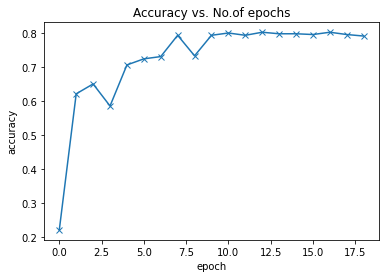

In [ ]:
plot_accuracies(history)

## Plotting the losses

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

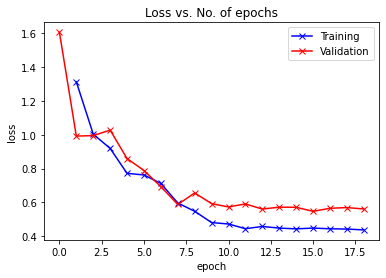

In [ ]:
plot_losses(history)

## Record the results

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=64, 
                       arch='Resnet9', 
                       epochs=[5, 3, 5, 5],
                       lrs=[.001, .0005, .0001, .0001],
                       opt=['Adam', 'Adam', 'SGD', 'SGD'])
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])


[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


In [ ]:
jovian.commit(project = 'deep-learning-project')

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/poduguvenu/deep-learning-project


'https://jovian.ai/poduguvenu/deep-learning-project'

## Test with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the validation dataset.

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

Target: rose
Prediction: tulip


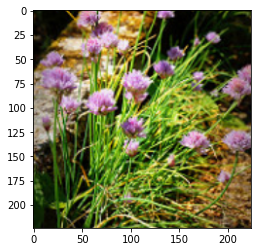

In [ ]:
img, label = valid_ds[0]
plt.imshow(img.permute((1, 2, 0)))
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

Target: dandelion
Prediction: sunflower


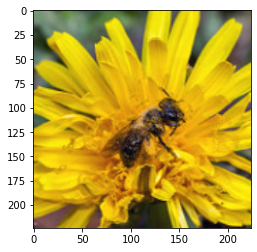

In [ ]:
img, label = valid_ds[100]
plt.imshow(img.permute((1, 2, 0)))
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

Target: sunflower
Prediction: sunflower


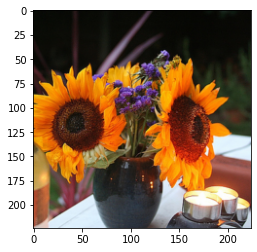

In [ ]:
img, label = valid_ds[150]
plt.imshow(img.permute((1, 2, 0)))
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

Target: rose
Prediction: rose


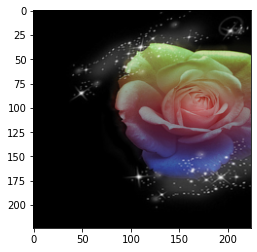

In [ ]:
img, label = valid_ds[350]
plt.imshow(img.permute((1, 2, 0)))
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

In [ ]:
def show_image_prediction(img, label):
  plt.imshow(img.permute((1, 2, 0)))
  pred = predict_image(img, model, dataset.classes)
  print('Target:', dataset.classes[label])
  print('Prediction:', pred)

Target: dandelion
Prediction: dandelion


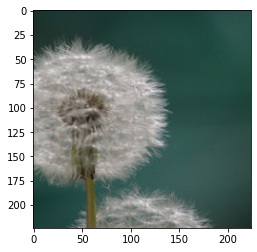

In [ ]:
show_image_prediction(*valid_ds[420])

Target: daisy
Prediction: daisy


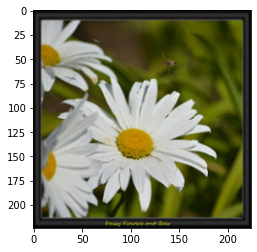

In [ ]:
show_image_prediction(*valid_ds[220])

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

# Save and Commit
Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [ ]:
torch.save(model.state_dict(), 'flowers-resnet9.pth')

In [ ]:
jovian.commit(project = 'deep-learning-project',
              outputs = ['flowers-resnet9.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/poduguvenu/deep-learning-project


'https://jovian.ai/poduguvenu/deep-learning-project'

# Transfer Learning

In [ ]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

In [ ]:
import torchvision.transforms as tt

img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir, tt.Compose([tt.Resize(img_size),
                                           tt.RandomCrop(img_size),
                                            tt.ToTensor(),
                                            tt.Normalize(*imagenet_stats)]))

In [ ]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

train_ds, valid_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(valid_ds)

batch_size = 32

train_dl = DataLoader(train_ds, 
                      batch_size,
                      shuffle = True,
                      num_workers = 4,
                      pin_memory = True)

valid_dl = DataLoader(valid_ds,
                    batch_size,
                    shuffle = True,
                    num_workers = 4, 
                    pin_memory = True)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(valid_dl, device)

In [ ]:
import torch
from tqdm.notebook import tqdm

@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)


def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader,
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []

    # Set up custom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs,
                                                steps_per_epoch=len(train_loader))

    for epoch in range(epochs):
        # Training Phase
        model.train()
        train_losses = []
        lrs = []
        for batch in tqdm(train_loader):
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()

            # Gradient clipping
            if grad_clip:
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)

            optimizer.step()
            optimizer.zero_grad()

            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()

        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
model = to_device(ResNet34(len(dataset.classes), pretrained=True), device)

In [ ]:
history = [evaluate(model, valid_dl)]
history

[{'val_acc': 0.1741071492433548, 'val_loss': 1.8725396394729614}]

In [ ]:
history += fit_one_cycle(10, 0.0005, model, train_dl, valid_dl, weight_decay=0.01, grad_clip=0.1, opt_func=torch.optim.Adam)


Epoch [0], train_loss: 0.5807, val_loss: 0.1862, val_acc: 0.9375



Epoch [1], train_loss: 0.3901, val_loss: 0.5935, val_acc: 0.8125



Epoch [2], train_loss: 0.5108, val_loss: 0.5485, val_acc: 0.7969



Epoch [3], train_loss: 0.5406, val_loss: 0.6457, val_acc: 0.8192



Epoch [4], train_loss: 0.5291, val_loss: 0.5938, val_acc: 0.7991



Epoch [5], train_loss: 0.4762, val_loss: 0.5596, val_acc: 0.8013



Epoch [6], train_loss: 0.3851, val_loss: 0.3994, val_acc: 0.8661



Epoch [7], train_loss: 0.2703, val_loss: 0.3263, val_acc: 0.8951



Epoch [8], train_loss: 0.1940, val_loss: 0.2733, val_acc: 0.9085



Epoch [9], train_loss: 0.1260, val_loss: 0.2597, val_acc: 0.9062


# Plotting accuracies

In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies, '-x')
  plt.xlabel('epoch')
  plt.ylabel('accuracy')
  plt.title('Accuracy vs. No.of epochs')

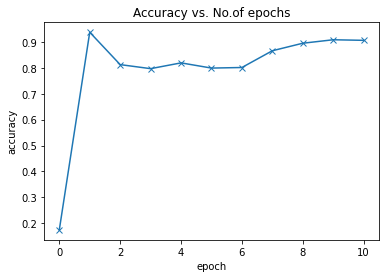

In [ ]:
plot_accuracies(history)

# Plotting losses

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

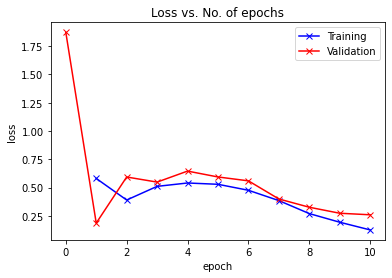

In [ ]:
plot_losses(history)

# Plotting learning rates
Finally, let's visualize how the learning rate changed over time, batch-by-batch over all the epochs.

In [ ]:
import numpy as np

def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

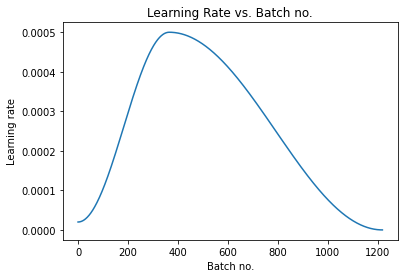

In [ ]:
plot_lrs(history)

# Record the results

In [ ]:
jovian.reset()
jovian.log_dataset(image_size=64)
jovian.log_hyperparams(batch_size=64, 
                       arch='Resnet34', 
                       epochs=[8],
                       lrs=[0.0005],
                       opt=['Adam'])
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_acc=history[-1]['val_acc'],
                   val_loss=history[-1]['val_loss'])

[jovian] Dataset logged.
[jovian] Hyperparams logged.
[jovian] Metrics logged.


## Test with individual images
While we have been tracking the overall accuracy of a model so far, it's also a good idea to look at model's results on some sample images. Let's test out our model with some images from the validation dataset.

In [ ]:
def denormalize(images, means, stds):
    if len(images.shape) == 3:
      images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [ ]:
def predict_image(img, model, classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

Label: rose (2)
Target: rose
Prediction: rose


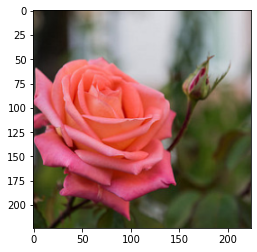

In [ ]:
img, label = valid_ds[0]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

Label: dandelion (1)
Target: dandelion
Prediction: sunflower


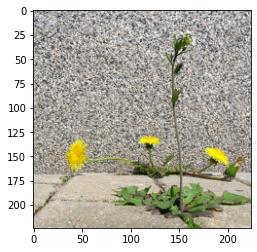

In [ ]:
img, label = valid_ds[100]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

Label: dandelion (1)
Target: dandelion
Prediction: dandelion


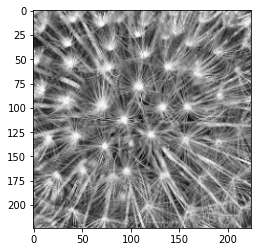

In [ ]:
img, label = valid_ds[150]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

Label: tulip (4)
Target: tulip
Prediction: tulip


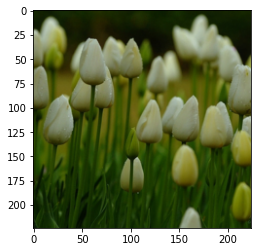

In [ ]:
img, label = valid_ds[350]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

Label: dandelion (1)
Target: dandelion
Prediction: dandelion


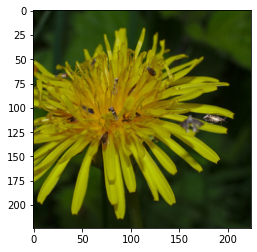

In [ ]:
img, label = valid_ds[420]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

Label: dandelion (1)
Target: dandelion
Prediction: dandelion


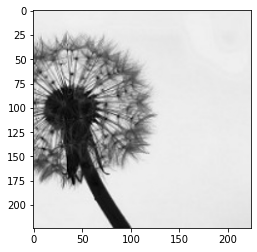

In [ ]:
img, label = valid_ds[220]
show_image(img, label)
pred = predict_image(img, model, dataset.classes)
print('Target:', dataset.classes[label])
print('Prediction:', pred)

Identifying where our model performs poorly can help us improve the model, by collecting more training data, increasing/decreasing the complexity of the model, and changing the hypeparameters.

# Save and Commit
Let's save the weights of the model, record the hyperparameters, and commit our experiment to Jovian. As you try different ideas, make sure to record every experiment so you can look back and analyze the results.

In [ ]:
torch.save(model.state_dict(), 'flowers-resnet34.pth')

In [ ]:
jovian.commit(project = 'deep-learning-project',
              outputs = ['flowers-resnet34.pth'])

[jovian] Detected Colab notebook...
[jovian] Uploading colab notebook to Jovian...
[jovian] Capturing environment..
[jovian] Uploading additional outputs...
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/poduguvenu/deep-learning-project


'https://jovian.ai/poduguvenu/deep-learning-project'